In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")


In [2]:
# Data Exploration – Ghost Particle ML Project
#This notebook explores real detector event data used to study weakly interacting ("ghost-like") particle signatures.

#Objectives: Understand feature distributions, Identify class imbalance. Detect potential data quality issues


In [20]:
data_path = "../data/raw/data.tab"


In [21]:
import os

os.listdir("../data/raw")


['data.tab']

In [22]:
df = pd.read_csv(
    data_path,
    sep=r"\s+",
    comment="#"
)


In [23]:
df.head

<bound method NDFrame.head of       id           mjd        ra       dec        f0        f1        f2  \
0      1  55351.322214  0.821759  0.113781  2.675354  0.659817  2.828038   
1      2  55351.465966  3.391436 -0.158430  3.046346 -0.521871 -2.923539   
2      3  55451.070748  2.231976 -0.605069  2.175865  2.231976  1.569496   
3      4  55477.393098  2.899470 -0.832452  2.403248  2.899470 -2.829608   
4      7  55571.258536  0.086326  0.236681  0.792669  0.417764  2.359098   
..   ...           ...       ...       ...       ...       ...       ...   
159  173  59726.852104  3.962043  0.214518  1.629622 -0.733129 -1.834300   
160  174  59732.337526  1.063348 -0.940080  1.328588  0.011968  1.998211   
161  175  59755.593502  3.224513  0.007798  1.562998 -3.058672  3.107871   
162  176  59788.347573  3.650810 -0.643967  3.090985  2.415627  0.030064   
163  177  59792.172619  2.684820 -0.158274  2.768061  2.437731  2.283418   

              f3          f4        f5        f6        f

In [24]:
df.shape


(164, 15)

In [25]:
df['reconstruction'].value_counts()


reconstruction
Shower    109
Track      55
Name: count, dtype: int64

In [26]:
df['energy'].describe()


count    1.640000e+02
mean     1.461524e+05
std      4.208808e+05
min      1.971976e+04
25%      3.784888e+04
50%      7.029877e+04
75%      1.162470e+05
max      4.802843e+06
Name: energy, dtype: float64

In [27]:
# Select features and target
X = df[['energy', 'drlogl']]
y = df['reconstruction']

# Quick sanity check
X.head(), y.head()


(       energy    drlogl
 0   44729.695 -0.023428
 1  101722.300 -0.033503
 2   67136.500 -0.936586
 3  144204.580  0.030818
 4   29600.297 -0.018292,
 0    Shower
 1    Shower
 2     Track
 3    Shower
 4    Shower
 Name: reconstruction, dtype: object)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check mapping
list(le.classes_), y_encoded[:10]


(['Shower', 'Track'], array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0]))

In [30]:
import numpy as np

unique, counts = np.unique(y_encoded, return_counts=True)
dict(zip(le.classes_, counts))


{'Shower': np.int64(109), 'Track': np.int64(55)}

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

X_train.shape, X_test.shape


((123, 2), (41, 2))

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [33]:
y_pred = rf.predict(X_test)


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

      Shower       1.00      1.00      1.00        27
       Track       1.00      1.00      1.00        14

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [35]:
confusion_matrix(y_test, y_pred)


array([[27,  0],
       [ 0, 14]])

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf,
    X,
    y_encoded,
    cv=cv,
    scoring='f1'
)

scores, scores.mean(), scores.std()


(array([0.91666667, 1.        , 1.        , 0.90909091, 0.95238095]),
 np.float64(0.9556277056277056),
 np.float64(0.039069114172704755))

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
confusion_matrix(y_test, y_pred_lr)


              precision    recall  f1-score   support

      Shower       0.93      1.00      0.96        27
       Track       1.00      0.86      0.92        14

    accuracy                           0.95        41
   macro avg       0.97      0.93      0.94        41
weighted avg       0.95      0.95      0.95        41



array([[27,  0],
       [ 2, 12]])

In [38]:
# Predictions and probabilities
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)

y_pred_lr[:10], y_prob_lr[:5]


(array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0]),
 array([[0.01431999, 0.98568001],
        [0.4428149 , 0.5571851 ],
        [0.30785058, 0.69214942],
        [0.92378303, 0.07621697],
        [0.89063068, 0.10936932]]))

In [39]:
import numpy as np

mis_idx = np.where(y_test != y_pred_lr)[0]
mis_idx


array([35, 40])

In [40]:
failed_events = X_test.iloc[mis_idx]
failed_events


,energy,drlogl
20,81364.590,-0.630240
100,23468.701,-0.545083


In [41]:
correct_tracks = X_test[(y_test == 1) & (y_pred_lr == 1)]
correct_tracks.describe()


,energy,drlogl
count,12.000000,12.000000
mean,63956.410750,-5.577979
std,42155.673016,4.642462
min,24099.504000,-13.411160
25%,33292.262500,-10.444778
50%,55734.130000,-4.045099
75%,75423.275000,-1.593461
max,167372.550000,-0.645607


In [43]:
# Track probability
track_probs = y_prob_lr[:, 1]

# Lower threshold to favor recall
custom_pred = (track_probs > 0.35).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, custom_pred, target_names=le.classes_))
confusion_matrix(y_test, custom_pred)


              precision    recall  f1-score   support

      Shower       1.00      1.00      1.00        27
       Track       1.00      1.00      1.00        14

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



array([[27,  0],
       [ 0, 14]])

In [44]:
import pandas as pd

importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
)

importances.sort_values(ascending=False)


drlogl    0.915197
energy    0.084803
dtype: float64

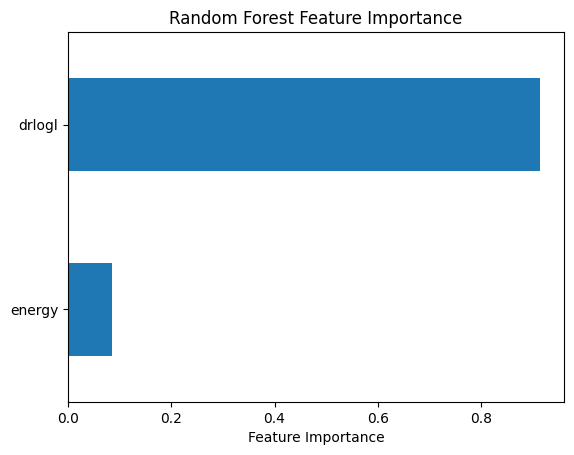

In [45]:
importances.sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [46]:
X_energy_only = df[['energy']]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_energy_only,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

rf_e = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_e.fit(X_train_e, y_train_e)
y_pred_e = rf_e.predict(X_test_e)

print(classification_report(y_test_e, y_pred_e, target_names=le.classes_))
confusion_matrix(y_test_e, y_pred_e)


              precision    recall  f1-score   support

      Shower       0.67      0.67      0.67        27
       Track       0.36      0.36      0.36        14

    accuracy                           0.56        41
   macro avg       0.51      0.51      0.51        41
weighted avg       0.56      0.56      0.56        41



array([[18,  9],
       [ 9,  5]])

In [47]:
# Use ONLY energy as the feature
X_energy = df[['energy']]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_energy,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

X_train_e.shape, X_test_e.shape


((123, 1), (41, 1))

In [48]:
rf_energy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_energy.fit(X_train_e, y_train_e)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [49]:
y_pred_e = rf_energy.predict(X_test_e)

print(classification_report(y_test_e, y_pred_e, target_names=le.classes_))
confusion_matrix(y_test_e, y_pred_e)


              precision    recall  f1-score   support

      Shower       0.67      0.67      0.67        27
       Track       0.36      0.36      0.36        14

    accuracy                           0.56        41
   macro avg       0.51      0.51      0.51        41
weighted avg       0.56      0.56      0.56        41



array([[18,  9],
       [ 9,  5]])

In [50]:
# Copy original features
X_noisy = X.copy()

# Add Gaussian noise to drlogl (10% of its std)
noise_level = 0.1 * X['drlogl'].std()
np.random.seed(42)

X_noisy['drlogl'] = X['drlogl'] + np.random.normal(
    loc=0,
    scale=noise_level,
    size=len(X)
)

X_noisy.head()


,energy,drlogl
0,44729.695,0.125053
1,101722.300,-0.074833
2,67136.500,-0.742975
3,144204.580,0.486091
4,29600.297,-0.088287


In [52]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_noisy,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_noisy.fit(Xn_train, yn_train)
yn_pred = rf_noisy.predict(Xn_test)

print(classification_report(yn_test, yn_pred, target_names=le.classes_))
confusion_matrix(yn_test, yn_pred)


              precision    recall  f1-score   support

      Shower       0.93      1.00      0.96        27
       Track       1.00      0.86      0.92        14

    accuracy                           0.95        41
   macro avg       0.97      0.93      0.94        41
weighted avg       0.95      0.95      0.95        41



array([[27,  0],
       [ 2, 12]])

In [53]:
# Continuous inference: P(Track | features)
track_prob = rf.predict_proba(X)[:, 1]

df_infer = df.copy()
df_infer['P_track'] = track_prob

df_infer[['energy', 'P_track']].head()


,energy,P_track
0,44729.695,0.005
1,101722.300,0.000
2,67136.500,0.995
3,144204.580,0.000
4,29600.297,0.005


In [54]:
# Energy bins
df_infer['energy_bin'] = pd.qcut(df_infer['energy'], q=6)

df_infer.groupby('energy_bin')['P_track'].mean()


C:\Users\Ninad Naik\AppData\Local\Temp\ipykernel_15612\897321662.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_infer.groupby('energy_bin')['P_track'].mean()


energy_bin
(19719.759, 33610.232]     0.408571
(33610.232, 45900.285]     0.367593
(45900.285, 70298.768]     0.318148
(70298.768, 99789.383]     0.394815
(99789.383, 143570.742]    0.293889
(143570.742, 4802843.0]    0.207500
Name: P_track, dtype: float64

In [55]:
grouped = df_infer.groupby('energy_bin', observed=True)['P_track']

summary = grouped.agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] / np.sqrt(summary['count'])

summary


,mean,std,count,sem
energy_bin,,,,
"(19719.759, 33610.232]",0.408571,0.462393,28,0.087384
"(33610.232, 45900.285]",0.367593,0.469841,27,0.090421
"(45900.285, 70298.768]",0.318148,0.454004,27,0.087373
"(70298.768, 99789.383]",0.394815,0.477458,27,0.091887
"(99789.383, 143570.742]",0.293889,0.455617,27,0.087684
"(143570.742, 4802843.0]",0.207500,0.391336,28,0.073955


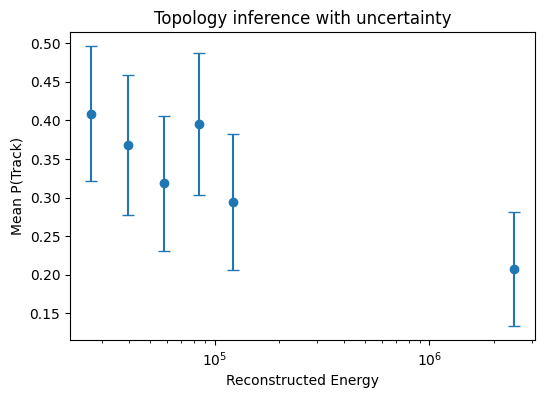

In [56]:
bin_centers = [interval.mid for interval in summary.index]

plt.figure(figsize=(6,4))
plt.errorbar(
    bin_centers,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o',
    capsize=4
)
plt.xscale('log')
plt.xlabel("Reconstructed Energy")
plt.ylabel("Mean P(Track)")
plt.title("Topology inference with uncertainty")
plt.show()


In [59]:
# Define bins
energy_bins = pd.qcut(df_infer['energy'], q=4)
drlogl_bins = pd.qcut(df_infer['drlogl'], q=4)

df_infer['energy_bin_2d'] = energy_bins
df_infer['drlogl_bin_2d'] = drlogl_bins


In [60]:
pivot = df_infer.pivot_table(
    values='P_track',
    index='drlogl_bin_2d',
    columns='energy_bin_2d',
    aggfunc='mean',
    observed=True
)

pivot


energy_bin_2d,"(19719.759, 37848.882]","(37848.882, 70298.768]","(70298.768, 116247.014]","(116247.014, 4802843.0]"
drlogl_bin_2d,,,,
"(-19.554000000000002, -1.073]",0.969000,0.992000,0.995000,0.955000
"(-1.073, -0.0495]",0.272059,0.398929,0.500714,0.001667
"(-0.0495, -0.0146]",0.009167,0.000500,0.010000,0.006923
"(-0.0146, 0.12]",0.008125,0.001429,0.005500,0.005938


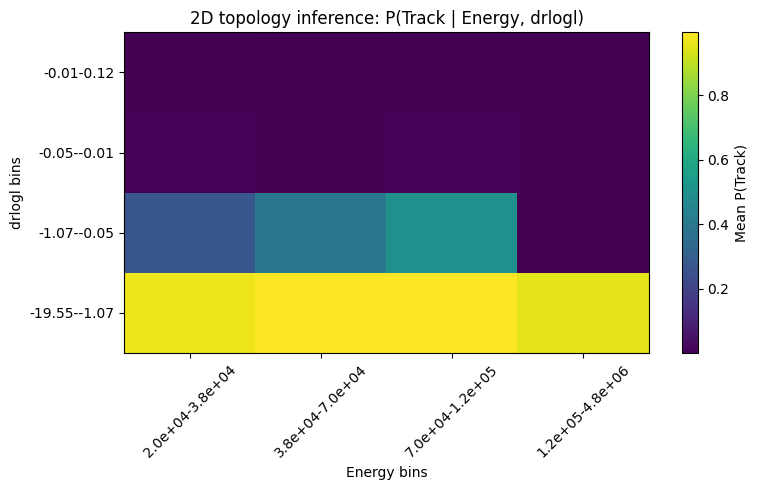

In [61]:
plt.figure(figsize=(8,5))
plt.imshow(pivot.values, aspect='auto', origin='lower')
plt.colorbar(label='Mean P(Track)')

plt.xticks(
    ticks=range(len(pivot.columns)),
    labels=[f"{c.left:.1e}-{c.right:.1e}" for c in pivot.columns],
    rotation=45
)
plt.yticks(
    ticks=range(len(pivot.index)),
    labels=[f"{i.left:.2f}-{i.right:.2f}" for i in pivot.index]
)

plt.xlabel("Energy bins")
plt.ylabel("drlogl bins")
plt.title("2D topology inference: P(Track | Energy, drlogl)")
plt.tight_layout()
plt.show()
